In [ ]:
# Standard Libraries
import sys
import os

# Data Handling and Numerical Operations
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

# Scikit-Learn: Preprocessing and Model Selection
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Scikit-Learn: Metrics and Reports
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

#Modeling
# Scikit-Learn: MLP-specific imports
from sklearn.neural_network import MLPClassifier

Preprocessing

In [ ]:
# Load the training data
df = pd.read_csv('/content/project_adult.csv', na_values='?')

# Load the validation data
df_validation = pd.read_csv('/content/project_validation_inputs.csv', na_values='?')

In [ ]:
# Convert the target variable 'income' to a binary format
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Display the initial count of missing values
print("Missing values before cleaning:")
print(df.isnull().sum())

# Handle missing values by imputing with the mode for all relevant columns
for col in ['workclass', 'occupation', 'native-country']:
    mode_val = df[col].mode()[0]
    df[col] = df[col].fillna(mode_val) # Using the warning-free method

print("\nMissing values after cleaning:")
print(df.isnull().sum())

Missing values before cleaning:
Unnamed: 0           0
age                  0
workclass         1447
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1454
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     458
income               0
dtype: int64

Missing values after cleaning:
Unnamed: 0        0
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


In [ ]:
# Calculate the mode for relevant columns from the TRAINING data
workclass_mode = df['workclass'].mode()[0]
occupation_mode = df['occupation'].mode()[0]
native_country_mode = df['native-country'].mode()[0] # This was originally a string, not a binary 0/1

# To be safe, let's re-read the original data to get the string mode for 'native-country'
# before it was converted to binary in the main 'df'
original_df = pd.read_csv('/content/project_adult.csv', na_values='?')
native_country_mode_str = original_df['native-country'].mode()[0]


print(f"Training data mode for 'workclass': {workclass_mode}")
print(f"Training data mode for 'occupation': {occupation_mode}")
print(f"Training data mode for 'native-country': {native_country_mode_str}")

Training data mode for 'workclass': Private
Training data mode for 'occupation': Prof-specialty
Training data mode for 'native-country': United-States


In [ ]:
# Engineer the 'relationship' feature by grouping categories
df['relationship'] = df['relationship'].replace({
    'Husband': 'Spouse',
    'Wife': 'Spouse',
    'Own-child': 'Child',
    'Not-in-family': 'Other',
    'Unmarried': 'Other',
    'Other-relative': 'Other'
})

# Convert 'sex' to a binary feature
df['sex'] = df['sex'].apply(lambda x: 1 if x == 'Male' else 0)

# Convert 'native-country' to a binary feature (US vs. Other)
df['native-country'] = df['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)

# One-hot encode all remaining object-type columns
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

print("\nDataFrame columns after encoding:")
print(df.columns)


DataFrame columns after encoding:
Index(['Unnamed: 0', 'age', 'fnlwgt', 'education-num', 'sex', 'capital-gain',
       'capital-loss', 'hours-per-week', 'native-country', 'income',
       'workclass_Local-gov', 'workclass_Never-worked', 'workclass_Private',
       'workclass_Self-emp-inc', 'workclass_Self-emp-not-inc',
       'workclass_State-gov', 'workclass_Without-pay', 'education_11th',
       'education_12th', 'education_1st-4th', 'education_5th-6th',
       'education_7th-8th', 'education_9th', 'education_Assoc-acdm',
       'education_Assoc-voc', 'education_Bachelors', 'education_Doctorate',
       'education_HS-grad', 'education_Masters', 'education_Preschool',
       'education_Prof-school', 'education_Some-college',
       'marital-status_Married-AF-spouse', 'marital-status_Married-civ-spouse',
       'marital-status_Married-spouse-absent', 'marital-status_Never-married',
       'marital-status_Separated', 'marital-status_Widowed',
       'occupation_Armed-Forces', 'occupati

In [ ]:
# Separate the target variable (y) from the features (X)
X = df.drop('income', axis=1)
y = df['income']

# Drop the original, unnamed index column
X = X.drop('Unnamed: 0', axis=1)

# Standardize only the numerical features
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nData shapes after splitting:")
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)


Data shapes after splitting:
Shape of X_train: (20838, 55)
Shape of X_test: (5210, 55)


In [ ]:
# Display the count of missing values before cleaning
print("Missing values in validation set before cleaning:")
print(df_validation.isnull().sum())
print("-" * 30)

# Impute missing values using the mode calculated from the TRAINING data (Warning-free method)
df_validation['workclass'] = df_validation['workclass'].fillna(workclass_mode)
df_validation['occupation'] = df_validation['occupation'].fillna(occupation_mode)
df_validation['native-country'] = df_validation['native-country'].fillna(native_country_mode)


print("\nMissing values in validation set after cleaning (imputation):")
print(df_validation.isnull().sum())
print("-" * 30)

print(f"\nShape of the validation dataframe after imputation: {df_validation.shape}")

Missing values in validation set before cleaning:
Unnamed: 0          0
age                 0
workclass         389
fnlwgt              0
education           0
education-num       0
marital-status      0
occupation        389
relationship        0
race                0
sex                 0
capital-gain        0
capital-loss        0
hours-per-week      0
native-country    125
dtype: int64
------------------------------

Missing values in validation set after cleaning (imputation):
Unnamed: 0        0
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
dtype: int64
------------------------------

Shape of the validation dataframe after imputation: (6513, 15)


In [ ]:
# Feature Engineering: Apply the same transformations as the training data
# Engineer the 'relationship' feature
if 'relationship' in df_validation.columns:
    df_validation['relationship'] = df_validation['relationship'].replace({
        'Husband': 'Spouse',
        'Wife': 'Spouse',
        'Own-child': 'Child',
        'Not-in-family': 'Other',
        'Unmarried': 'Other',
        'Other-relative': 'Other'
    })

# Convert 'sex' to a binary feature
if 'sex' in df_validation.columns:
    df_validation['sex'] = df_validation['sex'].apply(lambda x: 1 if x == 'Male' else 0)

# Convert 'native-country' to binary (US vs. Other)
if 'native-country' in df_validation.columns:
    df_validation['native-country'] = df_validation['native-country'].apply(lambda x: 1 if x == 'United-States' else 0)

print("\nValidation data after feature engineering:")
display(df_validation.head())
print("\nValidation data dtypes after feature engineering:")
display(df_validation.dtypes)


Validation data after feature engineering:


,Unnamed: 0,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,14160,27,Private,160178,Some-college,10,Divorced,Adm-clerical,Other,White,0,0,0,38,1
1,27048,45,State-gov,50567,HS-grad,9,Married-civ-spouse,Exec-managerial,Spouse,White,0,0,0,40,1
2,28868,29,Private,185908,Bachelors,13,Married-civ-spouse,Exec-managerial,Spouse,Black,1,0,0,55,1
3,5667,30,Private,190040,Bachelors,13,Never-married,Machine-op-inspct,Other,White,0,0,0,40,1
4,7827,29,Self-emp-not-inc,189346,Some-college,10,Divorced,Craft-repair,Other,White,1,2202,0,50,1



Validation data dtypes after feature engineering:


,0
Unnamed: 0,int64
age,int64
workclass,object
fnlwgt,int64
education,object
education-num,int64
marital-status,object
occupation,object
relationship,object
race,object


In [ ]:
# Drop the original, unnamed index column from validation set if it exists
if 'Unnamed: 0' in df_validation.columns:
    df_validation = df_validation.drop('Unnamed: 0', axis=1)

# One-hot encode all remaining object-type columns
categorical_cols_validation = df_validation.select_dtypes(include=['object']).columns
df_validation = pd.get_dummies(df_validation, columns=categorical_cols_validation, drop_first=True)

print("\nValidation data after one-hot encoding:")
display(df_validation.head())
print("\nValidation data dtypes after one-hot encoding:")
display(df_validation.dtypes)


Validation data after one-hot encoding:


,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,native-country,workclass_Local-gov,workclass_Private,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Other,relationship_Spouse,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,27,160178,10,0,0,0,38,1,False,True,...,False,False,False,False,True,False,False,False,False,True
1,45,50567,9,0,0,0,40,1,False,False,...,False,False,False,False,False,True,False,False,False,True
2,29,185908,13,1,0,0,55,1,False,True,...,False,False,False,False,False,True,False,True,False,False
3,30,190040,13,0,0,0,40,1,False,True,...,False,False,False,False,True,False,False,False,False,True
4,29,189346,10,1,2202,0,50,1,False,False,...,False,False,False,False,True,False,False,False,False,True



Validation data dtypes after one-hot encoding:


,0
age,int64
fnlwgt,int64
education-num,int64
sex,int64
capital-gain,int64
capital-loss,int64
hours-per-week,int64
native-country,int64
workclass_Local-gov,bool
workclass_Private,bool


In [ ]:
# Align columns of validation set with training set
# This ensures the validation set has the exact same columns as the training set
# Missing columns in validation set will be added and filled with 0
# Extra columns in validation set will be dropped
X_train_columns = X_train.columns
df_validation_aligned = df_validation.reindex(columns=X_train_columns, fill_value=0)


# Standardize numerical features using the *same scaler* fitted on the training data
numerical_cols = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
# Ensure that the columns to be scaled exist in the validation set
numerical_cols_validation = [col for col in numerical_cols if col in df_validation_aligned.columns]

# Use the already fitted scaler from the training data
df_validation_aligned[numerical_cols_validation] = scaler.transform(df_validation_aligned[numerical_cols_validation])

# Assign the processed validation data to X_validation
X_validation = df_validation_aligned

print("\nProcessed Validation Data Shapes:")
print("Shape of X_validation:", X_validation.shape)

print("\nProcessed Validation Data Head:")
display(X_validation.head())

print("\nProcessed Validation Data Types:")
display(X_validation.dtypes)


Processed Validation Data Shapes:
Shape of X_validation: (6513, 55)

Processed Validation Data Head:


,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,native-country,workclass_Local-gov,workclass_Never-worked,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Other,relationship_Spouse,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,-0.848554,-0.281107,-0.031277,0,-0.145715,-0.217998,-0.193705,1,False,0,...,False,False,False,False,True,False,False,False,False,True
1,0.470839,-1.322731,-0.419604,0,-0.145715,-0.217998,-0.031510,1,False,0,...,False,False,False,False,False,True,False,False,False,True
2,-0.701954,-0.036597,1.133702,1,-0.145715,-0.217998,1.184946,1,False,0,...,False,False,False,False,False,True,False,True,False,False
3,-0.628655,0.002669,1.133702,0,-0.145715,-0.217998,-0.031510,1,False,0,...,False,False,False,False,True,False,False,False,False,True
4,-0.701954,-0.003926,-0.031277,1,0.158821,-0.217998,0.779460,1,False,0,...,False,False,False,False,True,False,False,False,False,True



Processed Validation Data Types:


,0
age,float64
fnlwgt,float64
education-num,float64
sex,int64
capital-gain,float64
capital-loss,float64
hours-per-week,float64
native-country,int64
workclass_Local-gov,bool
workclass_Never-worked,int64


In [ ]:
display(df.head())
display(df.dtypes)

,Unnamed: 0,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,native-country,income,...,occupation_Protective-serv,occupation_Sales,occupation_Tech-support,occupation_Transport-moving,relationship_Other,relationship_Spouse,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,5514,33,198183,13,0,0,0,50,1,1,...,False,False,False,False,True,False,False,False,False,True
1,19777,36,86459,11,1,0,1887,50,1,1,...,False,False,False,False,False,True,False,False,False,True
2,10781,58,203039,5,1,0,0,40,1,0,...,False,False,False,False,True,False,False,False,False,True
3,32240,21,180190,11,1,0,0,46,1,0,...,False,False,False,False,False,True,False,False,False,True
4,9876,27,279872,10,1,0,0,40,1,0,...,False,False,False,False,True,False,False,False,False,True


,0
Unnamed: 0,int64
age,int64
fnlwgt,int64
education-num,int64
sex,int64
capital-gain,int64
capital-loss,int64
hours-per-week,int64
native-country,int64
income,int64


Modelling

Training the baseline MLP model...


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Training complete.

--- Baseline Model Evaluation ---
Accuracy: 0.8284

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89      3956
           1       0.65      0.62      0.64      1254

    accuracy                           0.83      5210
   macro avg       0.77      0.76      0.76      5210
weighted avg       0.83      0.83      0.83      5210


Confusion Matrix:
[[3536  420]
 [ 474  780]]


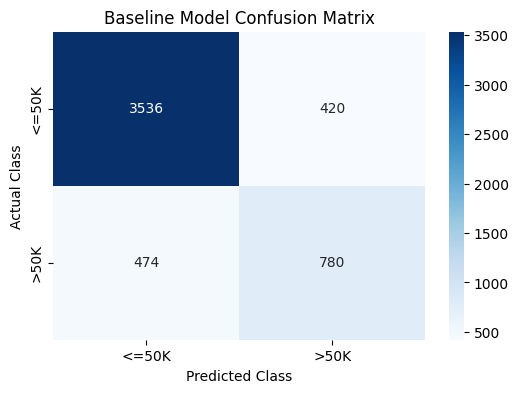

In [ ]:
# --- Model 1: Baseline MLP Classifier ---

# - hidden_layer_sizes=(50, 25)
# - activation='relu'
mlp_baseline = MLPClassifier(hidden_layer_sizes=(50, 25), max_iter=300, activation='relu', solver='adam', random_state=42)

# Train the model on the training data
print("Training the baseline MLP model...")
mlp_baseline.fit(X_train, y_train)
print("Training complete.")

# Make predictions on the test set
y_pred_baseline = mlp_baseline.predict(X_test)

# Evaluate the baseline model's performance
print("\n--- Baseline Model Evaluation ---")
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy: {baseline_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline))


# Calculate and store the confusion matrix
cm_baseline = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(cm_baseline)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_baseline, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Baseline Model Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

Starting GridSearchCV for hyperparameter tuning...
Fitting 3 folds for each of 24 candidates, totalling 72 fits

--- Best Model Evaluation (from GridSearchCV) ---
Best Parameters Found:
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}

Accuracy of the best model: 0.8522

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.92      0.90      3956
           1       0.72      0.63      0.67      1254

    accuracy                           0.85      5210
   macro avg       0.80      0.78      0.79      5210
weighted avg       0.85      0.85      0.85      5210


Confusion Matrix:
[[3653  303]
 [ 467  787]]


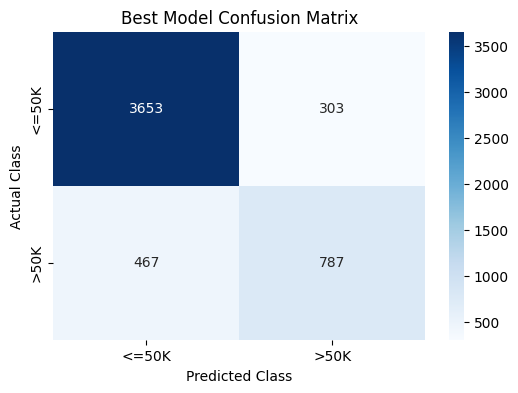

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50, 50), (100,), (64, 128)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'alpha': [0.0001, 0.05], # Alpha is the L2 regularization term
    'learning_rate': ['constant','adaptive'],
}

# Initialize GridSearchCV
# - cv=3: Use 3-fold cross-validation. For a final, more robust search, you might use cv=5.
grid_search = GridSearchCV(
    MLPClassifier(max_iter=300, random_state=42),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# --- Evaluate the Best Model Found by GridSearchCV ---

print("\n--- Best Model Evaluation (from GridSearchCV) ---")
# Get the best model
best_mlp = grid_search.best_estimator_

# Print the best parameters found
print("Best Parameters Found:")
print(grid_search.best_params_)

# Make predictions with the best model
y_pred_best = best_mlp.predict(X_test)

# Evaluate the best model's performance
best_accuracy = accuracy_score(y_test, y_pred_best)
print(f"\nAccuracy of the best model: {best_accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


# Calculate and store the confusion matrix for the best model
cm_best = confusion_matrix(y_test, y_pred_best)
print("\nConfusion Matrix:")
print(cm_best)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt='d', cmap='Blues', xticklabels=['<=50K', '>50K'], yticklabels=['<=50K', '>50K'])
plt.title('Best Model Confusion Matrix')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.show()

In [ ]:
# Predict on the final validation inputs using your best model
final_predictions = best_mlp.predict(X_validation)
# Transform the predictions: 1 stays 1, and 0 becomes -1
formatted_predictions = [1 if x == 1 else -1 for x in final_predictions]

# Create a DataFrame for submission
submission_df = pd.DataFrame({'prediction': formatted_predictions})

print(submission_df.shape)

# Save to CSV
submission_df.to_csv('Group_12_MLP_PredictedOutputs.csv', index=False)

(6513, 1)


Questions:

1. Why did you choose the specific architecture for each model?
-------------------------------------------------------------

Why an MLP?

 because our preprocessed data is tabular and contains complex, non-linear relationships between features that a simpler linear model would miss. After one-hot encoding, we had 55 input features, and an MLP is  to learn from this kind of structured, high-dimensional input.


 Depth and Width (Number of Layers and Neurons):

 We used GridSearchCV to empirically test different network structures. Specifically, our search space included:
A wider, single-hidden-layer network: (100,). This architecture is good at learning many features at the same level of abstraction.


A deeper, two-hidden-layer network: (50, 50). This structure allows the model to learn hierarchical features—the first layer learns basic patterns, and the second layer combines those to learn more complex interactions.
This allowed us to determine if a deeper or wider network was more effective for this specific dataset.


Activation Function: We tested two common activation functions:
ReLU (Rectified Linear Unit): This is the modern default for hidden layers because it is computationally fast and helps prevent the "vanishing gradient" problem, allowing for more stable training.

Tanh (Hyperbolic Tangent): We included Tanh to see if a bounded activation function (which outputs values between -1 and 1) could help define the class boundaries more effectively in our specific classification problem.

2. How did you monitor and mitigate overfitting in your models?
-------------------------------------------------------------

**Train/Test split:**

Our first and most important step was splitting the data using train_test_split. We kept 20% of the data as a final holdout test set. This set was never touched during model training or tuning, giving us access to an unbiased dataset.

**3 Fold Cross validation in gridsearchCV:**

Instead of relying on a single validation set, we used 3-fold cross-validation within our GridSearchCV. This process splits the training data into 3 parts, training on two and validating on the third, and then rotating.

**L2 Regularization:**

 controlled model complexity by tuning the alpha parameter for L2 regularization. A higher alpha value is a stronger penalty on large neuron weights, forcing the model to learn simpler and more generalizable patterns rather than memorizing the training data.

**Controlled Model Complexity**

 Our GridSearchCV intentionally explored relatively simple architectures ((100,), (50, 50), and (64.128)). By not testing large or deep networks, we limited the model's capacity to overfit the training data.



3. What ethical concerns might arise from deploying models trained on these datasets?
-------------------------------------------------------------

**Historical biases:**

Sensitive features (e.g., sex, race, marital status, native country) can encode inequities. Because this data reflects real-world societal structures, it likely contains historical and systemic biases



**Governance:**

Issue could arise on who would be held accountable for the models errors.



4. Why are activation functions necessary in neural networks?
-------------------------------------------------------------

One of the main ones things we used mlp for was to overcome the linear decision boundary was the addition of activation functions.

They're absolutely necessary because of how they bend and shape the decision boundary. This is why it can be non-linear in comparison to perceptron




